In [ ]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [ ]:
import matplotlib.pyplot as plt

from tensorflow.keras import layers, Sequential
from tensorflow.keras.applications import ResNet50, ConvNeXtBase
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.utils import image_dataset_from_directory

from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def build_and_compile_model(transferred_model, num_classes):

	for layer in transferred_model.layers:
	    layer.trainable = False

	model = Sequential([
	    transferred_model,
	    layers.GlobalAveragePooling2D(),
	    layers.Dense(256, activation='relu'),
	    layers.Dropout(0.5),
	    layers.Dense(256, activation='relu'),
	    layers.Dropout(0.5),
	    layers.Dense(num_classes, activation='softmax')
	])

	model.compile(
	    optimizer='adam',
	    loss='categorical_crossentropy',
	    metrics=['accuracy']
	)

	return model


def build_and_train_model(transferred_model, num_classes, epochs, datasets, trained_model_path, logs_path):

	model = build_and_compile_model(transferred_model, num_classes)

	history = model.fit(
		x=datasets['train'],
		validation_data=datasets['validation'],
		epochs=epochs,
		callbacks=[
			ModelCheckpoint(trained_model_path, save_best_only=True),
			CSVLogger(logs_path)
		],
		batch_size=32
	)

	loss, accuracy = model.evaluate(datasets['test'])

	return model, history, loss, accuracy


def plot_loss_and_accuracy(history, loss_ylim=[0, 2], accuracy_ylim=[0, 1]):
	fig, axes = plt.subplots(1, 2, figsize=(12, 5))

	ax = axes[0]
	ax.set_title('Loss')
	ax.set_ylim(loss_ylim)

	plot_data = history['loss']
	ax.plot(range(len(plot_data)), plot_data, color='blue')

	plot_data = history['val_loss']
	ax.plot(range(len(plot_data)), plot_data, color='orange')

	ax = axes[1]
	ax.set_title('Accuracy')
	ax.set_ylim(accuracy_ylim)

	plot_data = history['accuracy']
	ax.plot(range(len(plot_data)), plot_data, color='blue')

	plot_data = history['val_accuracy']
	ax.plot(range(len(plot_data)), plot_data, color='orange')

	plt.show();

In [ ]:
dataset_path = '/content/drive/MyDrive/OpenClassrooms/06/sample_data/'

datasets = {
    'train':      image_dataset_from_directory(directory=dataset_path + 'train/', label_mode='categorical'),
    'validation': image_dataset_from_directory(directory=dataset_path + 'val/', label_mode='categorical'),
    'test':       image_dataset_from_directory(directory=dataset_path + 'test/', label_mode='categorical')
}

base_target_path = '/content/drive/MyDrive/OpenClassrooms/07/'

Found 12307 files belonging to 120 classes.
Found 4111 files belonging to 120 classes.
Found 4162 files belonging to 120 classes.


In [ ]:
# Baseline model training

baseline_results = build_and_train_model(
    transferred_model=ResNet50(include_top=False, weights="imagenet", input_shape=(256, 256, 3)),
    num_classes=120,
    epochs=10,
    datasets=datasets,
    trained_model_path=base_target_path + 'models/V57/baseline_model.h5',
    logs_path=base_target_path + 'training_logs/V57/baseline_model_training_log.csv'
)

94765736/94765736 [==============================] - 6s 0us/step
Epoch 1/10
385/385 [==============================] - ETA: 0s - loss: 4.3933 - accuracy: 0.0445 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


385/385 [==============================] - 7312s 19s/step - loss: 4.3933 - accuracy: 0.0445 - val_loss: 3.2808 - val_accuracy: 0.2501
Epoch 2/10
385/385 [==============================] - 83s 213ms/step - loss: 3.5189 - accuracy: 0.1265 - val_loss: 2.5920 - val_accuracy: 0.3676
Epoch 3/10
385/385 [==============================] - 84s 215ms/step - loss: 3.1710 - accuracy: 0.1714 - val_loss: 2.2825 - val_accuracy: 0.4084
Epoch 4/10
385/385 [==============================] - 84s 214ms/step - loss: 2.9883 - accuracy: 0.1981 - val_loss: 2.1545 - val_accuracy: 0.4600
Epoch 5/10
385/385 [==============================] - 81s 208ms/step - loss: 2.8277 - accuracy: 0.2252 - val_loss: 2.1050 - val_accuracy: 0.4653
Epoch 6/10
385/385 [==============================] - 82s 211ms/step - loss: 2.7221 - accuracy: 0.2424 - val_loss: 1.9839 - val_accuracy: 0.4809
Epoch 7/10
385/385 [==============================] - 84s 215ms/step - loss: 2.6077 - accuracy: 0.2681 - val_loss: 1.9524 - val_accuracy: 0.4

In [ ]:
# Challenger model training

challenger_results = build_and_train_model(
    transferred_model=ConvNeXtBase(include_top=False, weights="imagenet", input_shape=(256, 256, 3)),
    num_classes=120,
    epochs=5,
    datasets=datasets,
    trained_model_path=base_target_path + 'models/V57/challenger_model.tf',
    logs_path=base_target_path + 'training_logs/V57/challenger_model_training_log.csv'
)

350926856/350926856 [==============================] - 2s 0us/step
Epoch 1/5
385/385 [==============================] - 4099s 10s/step - loss: 1.8943 - accuracy: 0.5586 - val_loss: 0.3896 - val_accuracy: 0.8886
Epoch 2/5
385/385 [==============================] - 417s 1s/step - loss: 0.6807 - accuracy: 0.8100 - val_loss: 0.3530 - val_accuracy: 0.8981
Epoch 3/5
385/385 [==============================] - 388s 1s/step - loss: 0.5407 - accuracy: 0.8463 - val_loss: 0.3538 - val_accuracy: 0.9049
Epoch 4/5
385/385 [==============================] - 415s 1s/step - loss: 0.4580 - accuracy: 0.8668 - val_loss: 0.3466 - val_accuracy: 0.9054
Epoch 5/5
131/131 [==============================] - 1064s 8s/step - loss: 0.3491 - accuracy: 0.9029


Baseline model test accuracy: 0.4971167743206024



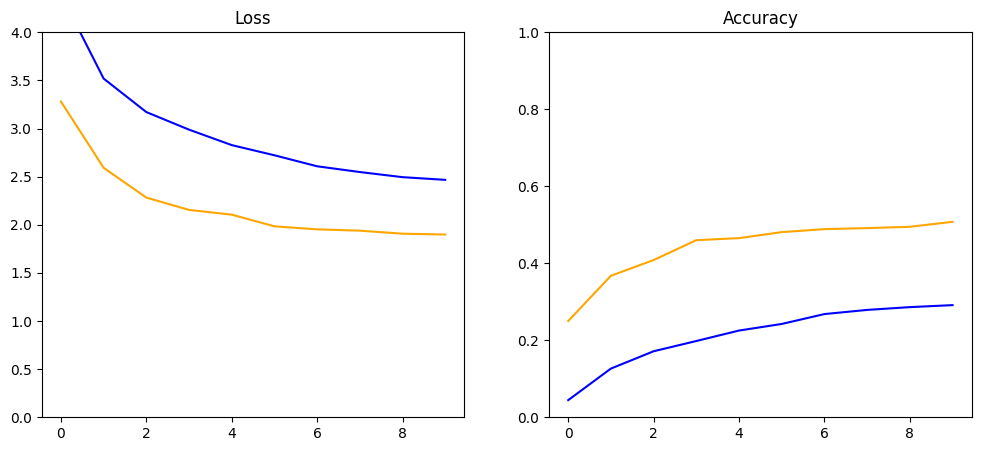

In [ ]:
# Baseline model results

print(f'Baseline model test accuracy: {baseline_results[3]}\n')

plot_loss_and_accuracy(
    history=baseline_results[1].history,
    loss_ylim=[0, 4]
)

Challenger model test accuracy: 0.902931272983551



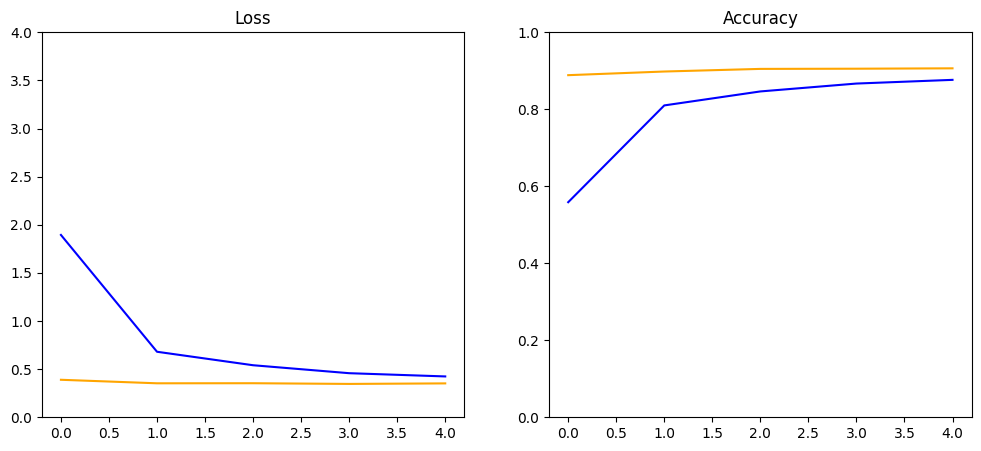

In [ ]:
# Challenger model results

print(f'Challenger model test accuracy: {challenger_results[3]}\n')

plot_loss_and_accuracy(
    history=challenger_results[1].history,
    loss_ylim=[0, 4]
)